In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
pd.set_option('future.no_silent_downcasting', True)

from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"..\..\Datasets\India\BeSample"

# DATA WRANGLING

In [3]:
df00 = pd.read_csv(rf"{import_folder_path}/Indian Risk Survey_Besample_Filtered_12_2024.csv", index_col = 0)
df00.rename({"ResponseId":"responseid"}, axis = 1, inplace = True)

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["responseid"]))

# removing students
df01 = df01.loc[ ~(df01["Q4"] == "Student")].copy()
print("Post removing students:", len(df01["responseid"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
conversion_dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(conversion_dict)

df01[ques] = pd.to_numeric(df01[ques], errors='coerce')

df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["responseid"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["responseid"]))

# <0.5 median time of completion filtered --> already done for this dataset
# df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
# median = df01["Duration (in seconds)"].astype("Int64").median()
# df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
# print("Post removing <0.5 median time responses:", len(df01["responseid"])) 

df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "responseid", range(0, len(df0)))

Post dropping NA: 370
Post removing students: 270
Post removing straightliners: 270
Post attention chaeck failures: 270


In [4]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b.1"].astype(float).copy()

In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts().sort_index())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4"].value_counts().sort_index())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts().sort_index())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts().sort_index())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[0, 1, 2, 3, 5, 4]])}')

Total Observations: 270

Gender:
Female    111
Male      159

Occupation:
Entrepreneur/Business Owner in a sector other than Finance      30
Insurance agent, etc                                             7
Not employed                                                    50
Retired                                                          3
Salaried/Employee/Consultant in a sector other than Finance    167
Stock analyst                                                   12
Venture capital/private equity                                   1

Education:
Diploma and Vocational Training          12
M.Phil.                                   1
Ph.D. and higher                          7
Post-Graduate Program                   106
Primary School (up to 10th Std.)          4
Secondary School (11th to 12th Std.)      8
Undergraduate Program                   132

ISCED:
1    114
2    144
3     12

Income:
< INR 500,000                    125
INR 500,001 – INR 15,00,000       96
INR 1500,001 – INR 

## Winsorizing Wealth: No winsorizing happening yet, look for top values, and their frequency

In [6]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

def winsorize_output(sample, variable, limits = [0, 0]):
    sample[f"nonwinsorised_{variable}"] = sample[variable]
    sample[f"winsorised_{variable}"] = winsorize(np.array(sample[f"nonwinsorised_{variable}"]), limits = limits, inclusive = [False, False])
    sample[[f"nonwinsorised_{variable}", f"winsorised_{variable}"]].describe()
    print(sample[[f"winsorised_{variable}", f"nonwinsorised_{variable}"]].describe())
    print("\n\nTop values and their count: ", (sample[f"nonwinsorised_{variable}"].value_counts().sort_index().tail(n=10)))
    print("\n\n")
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    sns.kdeplot(data = sample[f"nonwinsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
    axes[0].set_title(f'Nonwinsorised {variable}')
    sns.kdeplot(data = sample[f"winsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
    axes[1].set_title(f'Winsorized {variable}')
    plt.tight_layout()
    plt.show()

    sample[variable] = sample[f"winsorised_{variable}"]
    return sample[variable]

       winsorised_wealth  nonwinsorised_wealth
count       2.700000e+02          2.700000e+02
mean        5.408065e+06          5.408065e+06
std         1.639383e+07          1.639383e+07
min         0.000000e+00          0.000000e+00
25%         2.000000e+05          2.000000e+05
50%         7.500000e+05          7.500000e+05
75%         4.000000e+06          4.000000e+06
max         1.500000e+08          1.500000e+08


Top values and their count:  nonwinsorised_wealth
16000000.0     1
20000000.0     7
25000000.0     1
30000000.0     3
40000000.0     1
50000000.0     2
85000000.0     1
100000000.0    2
120000000.0    1
150000000.0    1
Name: count, dtype: int64





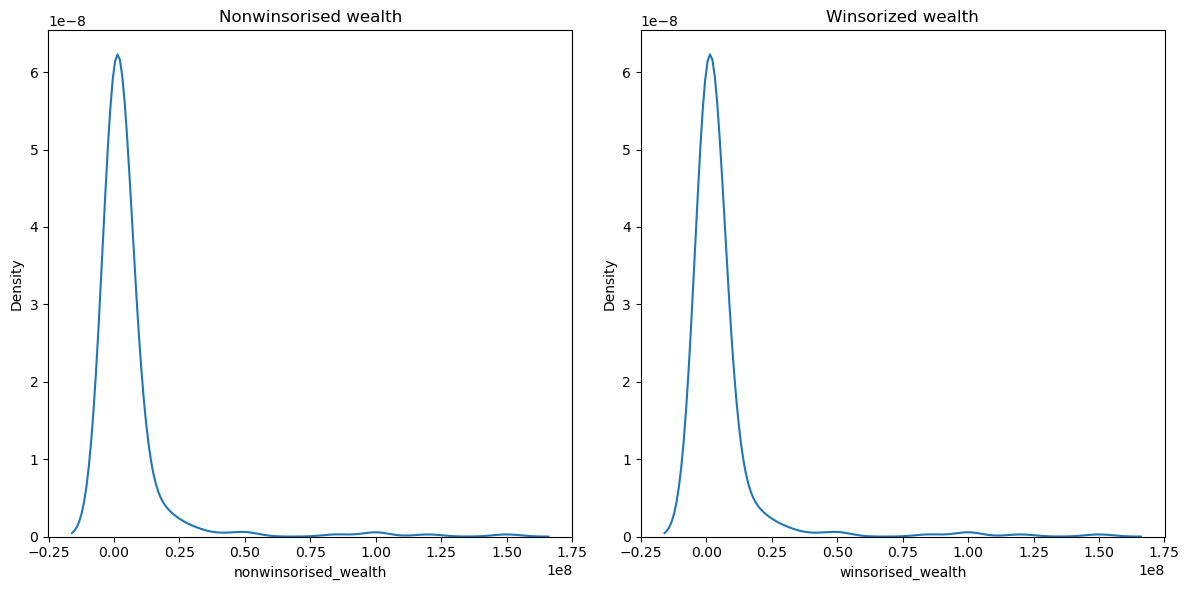

In [7]:
winsorized_wealth = winsorize_output(df0, "wealth", [0, 0])

In [8]:
# Using winsorised wealth as wealth
df0["wealth"] = winsorized_wealth

## Questions

In [9]:
df0.columns

Index(['responseid', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5_1', 'Q6_1', 'Q8_1', 'Q8_2',
       'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6', 'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4',
       'Q9b_5', 'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_9', 'Q11a_1', 'Q11a_2',
       'Q11a_3', 'Q11b', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i',
       'Q12a', 'Q12b', 'Q12c', 'Q13a', 'Q13b', 'Q13c', 'Q13d', 'Q14a', 'Q14b',
       'Q14c', 'Q15a', 'Q14b.1', 'response_id', 'assignment_id', 'besample_id',
       'completion_code', 'Q8_std', 'age', 'age_rec', 'isced', 'income',
       'wealth', 'nonwinsorised_wealth', 'winsorised_wealth'],
      dtype='object')

In [10]:
df0["q8_2_1"] = np.where(df0["Q11b"].str.contains("HIV test"), 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b"].str.contains("Fingerprint"), 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b"].str.contains("DNA test"), 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b"].str.contains("Cancer screening test"), 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b"].str.contains("Professional horoscope"), 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [11]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"] == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].copy()
df0["q9_2_1"] = df0["Q14b"].copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [12]:
df0["q10_1_1"] = df0["Q13a"].copy()
df0["q10_2_1"] = df0["Q13b"].copy()
df0["q10_3_1"] = df0["Q13c"].copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [13]:
#BeSample Only

df0["Q12a_score"] = np.where(df0["Q12a"] == "More than INR 102", 1, 0)
df0["Q12b_score"] = np.where(df0["Q12b"] == "Less than today with the money in this account", 1, 0)
df0["Q12c_score"] = np.where(df0["Q12c"] == "False", 1, 0)

cols = ["Q12a_score", "Q12b_score", "Q12c_score"]
df0["Q12_total"] = df0[cols].sum(axis = 1)

## SCORING

In [14]:
focal_col = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5",
             "q8_3", "q8_4",
             "q8_5berlin_1", "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7",
             "q9_1_1", "q9_2_1", "q9_3",
             "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]

for col in focal_col:
    df0[col] = df0[col].astype(float)

scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
"uncertainty1", "uncertainty2",
"numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
"graph1", "graph2", "graph3",
"riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
"bayesian1"
]

# BeSample Only
req_cols = ["financialliteracy"]

df0[scoreColumns + req_cols] = 0

In [15]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # BeSample Only
    surveyFacet.loc[:, "financialliteracy"] = surveyFacet["Q12_total"]

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [16]:
df1 = df0.groupby(["responseid"]).progress_apply(scoring1)
df1 = df1.reset_index(drop = True).copy()

 99%|███████████████████████████████████████████████████████████████████████████████▍| 268/270 [00:02<00:00, 98.34it/s]C:\Users\SHIVAM\anaconda3\Lib\site-packages\tqdm\std.py:805: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [00:03<00:00, 83.26it/s]


In [17]:
def scoring2(survey):
    
    survey["Certainty_4"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_18"] = (survey["Certainty_4"] + 
                               survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"])
    
    survey["Certainty_%"] = survey["Certainty_4"] / 4 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_18"] / 18 * 100

    #BeSample Only
    survey["FinancialLiteracy_3"] = survey["Q12_total"]
    survey["FinancialLiteracy_%"] = survey["FinancialLiteracy_3"] / 3 * 100
    
    
    colReq = [
        "responseid", "age", "age_rec", "isced", "income", "wealth", "Certainty_4",
        "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
        "Numeracy_3", "Bayesianreasoning_1", "Certainty_%",
        "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
        "TotalScore_18", "TotalScore_%",
        # BeSample ONly
        "FinancialLiteracy_%", "FinancialLiteracy_3"]
    
    survey1 = survey[colReq].copy()
    return survey1

In [18]:
df2 = scoring2(df1)

In [19]:
main = df2.copy()

In [20]:
# will be used later
wealth_quartile = pd.qcut(main.loc[~ (main["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" )

## Income Terciles and Quartiles

How to Form Terciles from Categorical Data
If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
5. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.

In [21]:
# main["income"].value_counts().sort_index() / len(main) * 100

### Income Terciles
1 - income = 1 --> 46.296296 (46.296296)

2 - income = 2 --> 35.555556 (35.555556)

3 - income = 3 4 5 6 --> 18 (10.000000 + 4.074074 + 1.851852 + 2.222222)

In [22]:
main["income_tercile"] = np.where(main["income"] == 1, 1,
                                  np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 3,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 3,
                                                                      np.where(main["income"] == 6, 3, -1
                                                                              )
                                                                     )
                                                            )
                                                   )
                                          )
                                 )                                  

### Income Quartiles - Not possible
1 - income = 

2 - income = 

3 - income = 

4 - income =

In [23]:
# main["income_quartile"] = np.where(main["income"] == 1, 1,
#                                    np.where(main["income"] == 2, 2,
#                                            np.where(main["income"] == 3, 3,
#                                                     np.where(main["income"] == 4, 3,
#                                                              np.where(main["income"] == 5, 4,
#                                                                       np.where(main["income"] == 6, 4, -1
#                                                                                )
#                                                                       )
#                                                              )
#                                                     )
#                                            )
#                                    )   

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

In [24]:
#Global Vras:
facet_cols = ["Certainty_4",
    "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3", "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%",
    "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - India BeSample - No students

## Graph 1.0 - Total Score Frequency Distribution

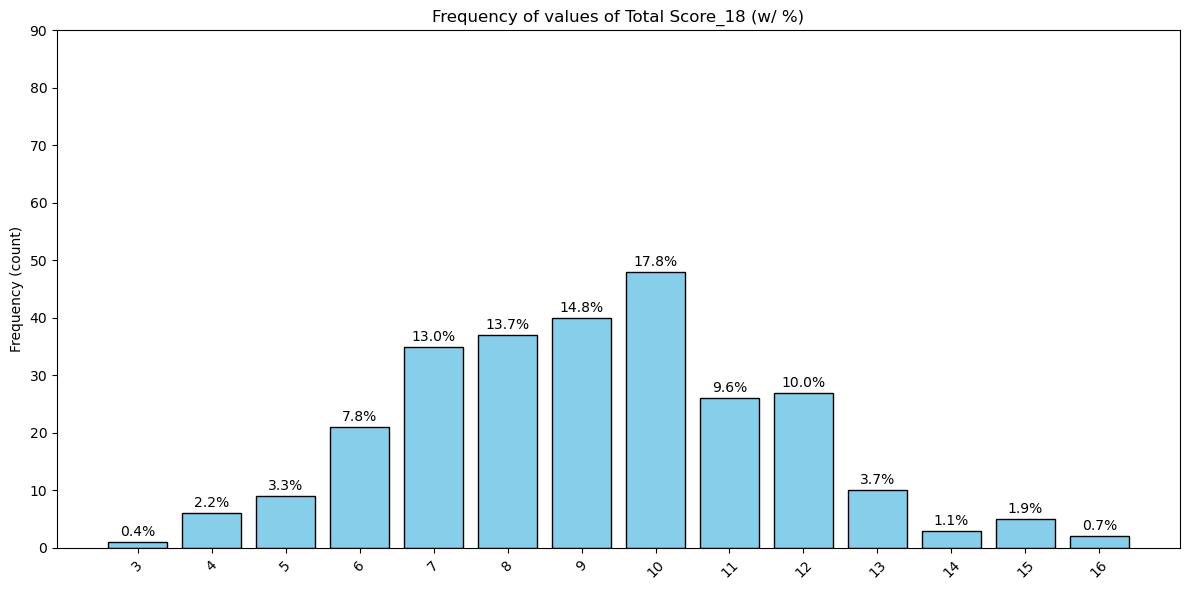

In [25]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = main["TotalScore_18"].value_counts().sort_index()
x = sample.index
y = sample.values
total = sample.sum()

axes.bar(x, y, color="skyblue", edgecolor='black')

for j, value in zip(sample.index, sample.values):
    axes.text(j, value + 0.5, f"{value/total * 100:.1f}%", ha = "center", va = "bottom", fontsize=10, color="black")

axes.set_yticks(np.arange(0, 100, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(x, rotation = 45, ha = "center")

axes.set_ylabel(f"Frequency (count)")
axes.set_title(f"Frequency of values of Total Score_18 (w/ %)")

plt.tight_layout()
plt.show()

## Table 1.1 - Mean Total Score + SD

Text(0, 0.5, 'Mean Total score')

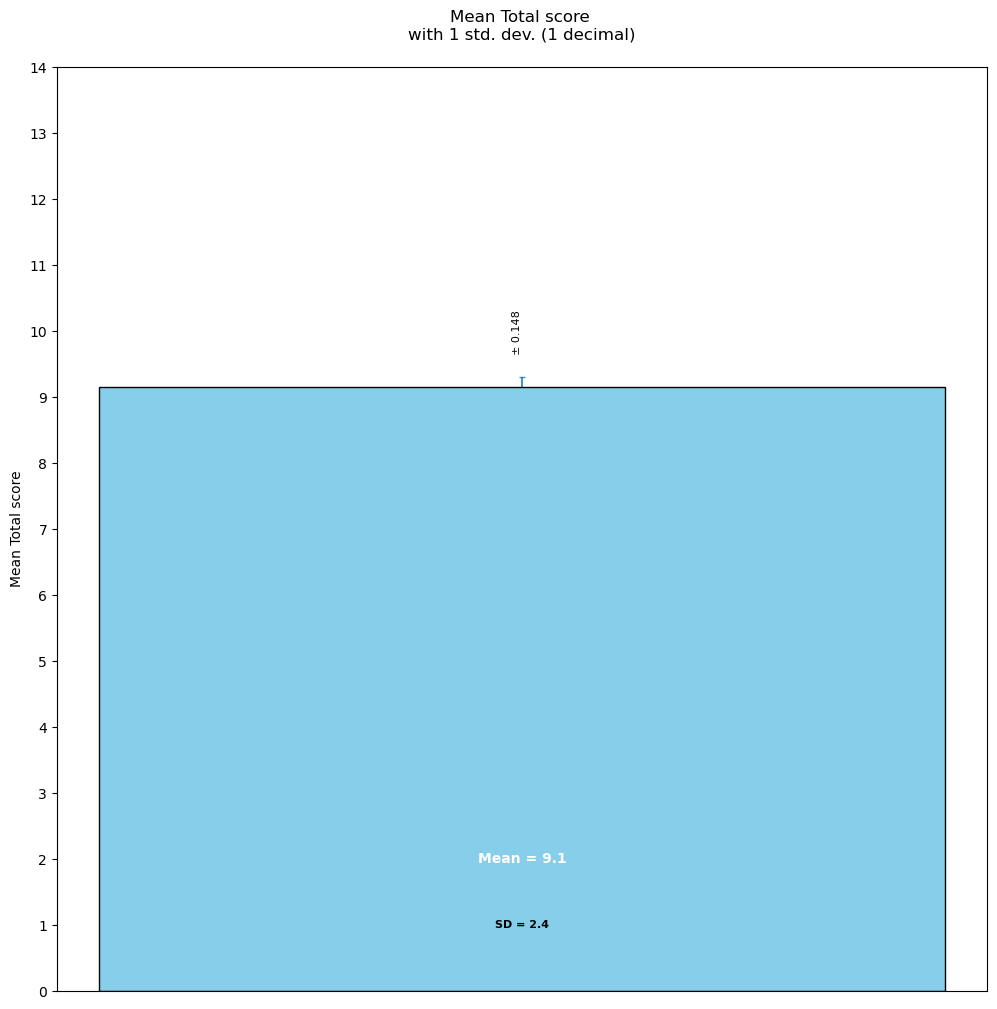

In [26]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_18"].mean()
std = main["TotalScore_18"].std()
sem = main["TotalScore_18"].sem()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 15))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)


axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 1, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score \nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

----------------------------------

## Table 1.2 - Mean Facet Scores + SD (Ver. 1)

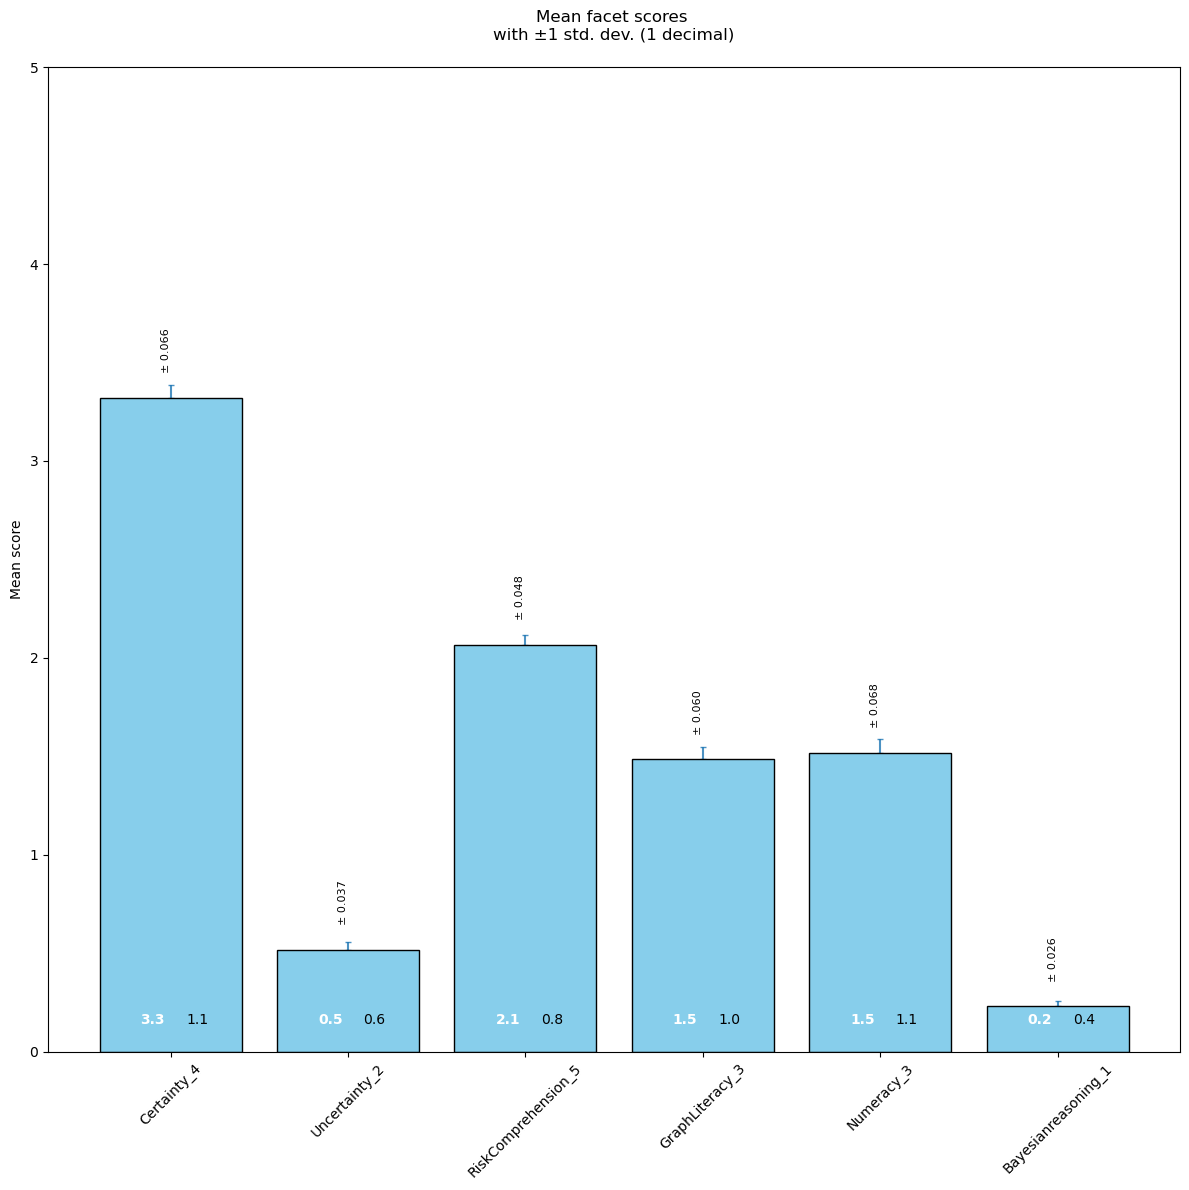

In [27]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_cols].mean()
std_scores = main[facet_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_cols].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 5
axes.set_yticks(np.arange(0, y_max + 1))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j - 0.1, 0.025 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j + 0.15, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10)

    

axes.set_title(f"Mean facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean score")


plt.tight_layout()
plt.show()

---

---

## Table 1.3 - M proportion of maximum (Total Score) score + SD + Median

Text(0, 0.5, 'Mean % score')

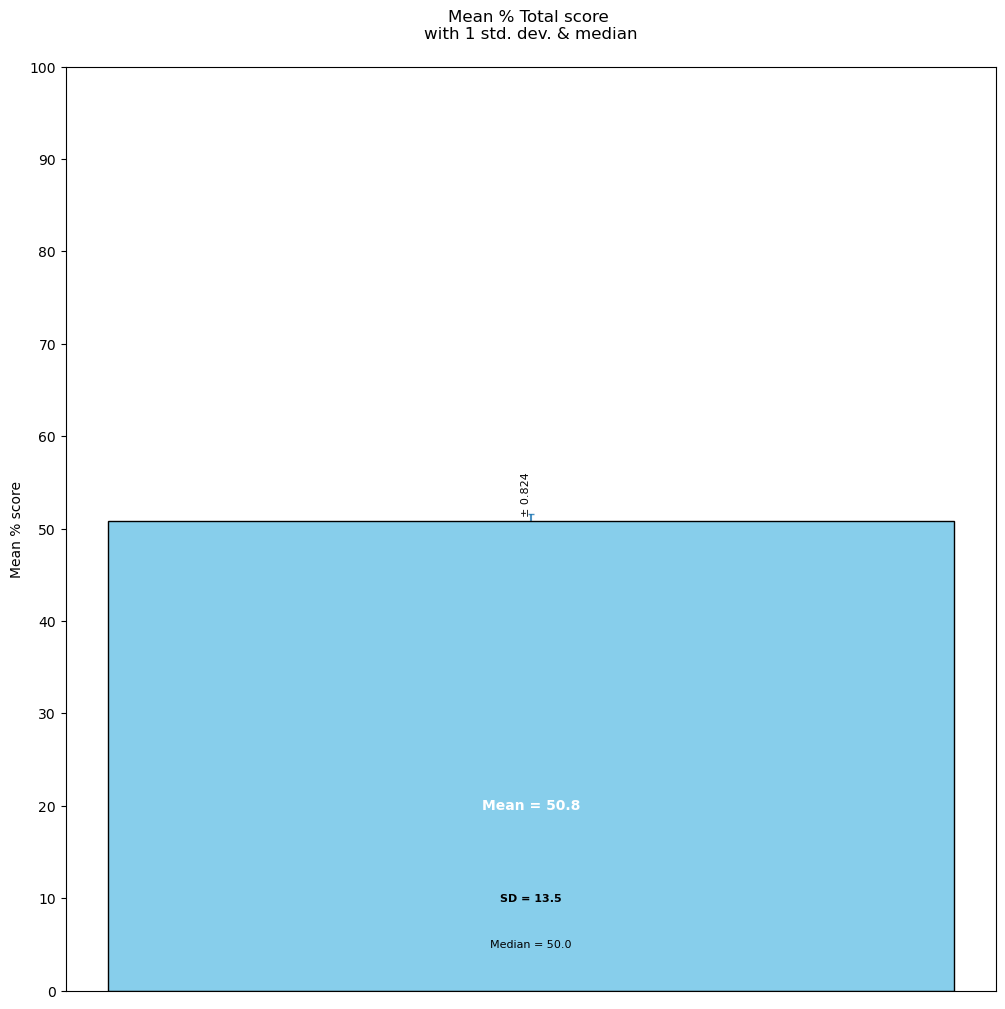

In [28]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_%"].mean()
std =  main["TotalScore_%"].std()
sem =  main["TotalScore_%"].sem()
med =  main["TotalScore_%"].median()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)

axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
axes.text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
          color='black', fontsize=8)
    

axes.set_title("Mean % Total score \nwith 1 std. dev. & median", pad = 20)
axes.set_ylabel("Mean % score")

----------------------------------

## Table 1.4 - M proportion of Facet Scores + SD + Median

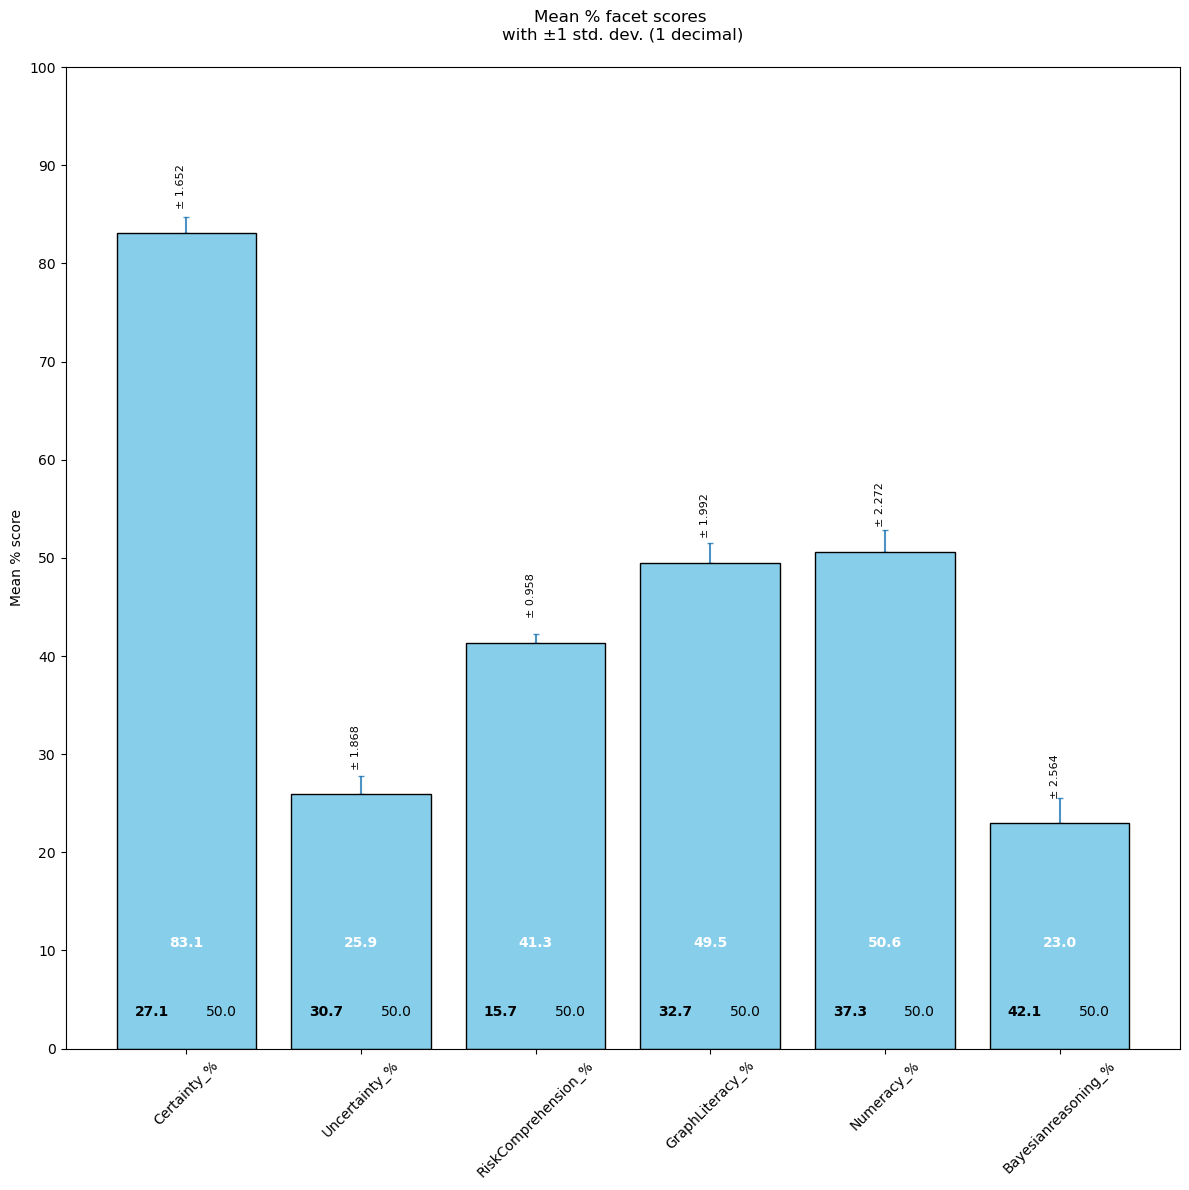

In [29]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_percent_cols].mean()
std_scores = main[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores = main[facet_percent_cols].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)

    

axes.set_title(f"Mean % facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean % score")
plt.tight_layout()
plt.show()

---

---

## Table 2.1 - Per income class: Mean Facet Scores + SD + Median

Note: Income Class has been filtered out of entries who opted out of disclosing their income

In [30]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()
income_filtered.income.value_counts()

income
1    125
2     96
3     27
4     11
6      6
5      5
Name: count, dtype: int64

In [31]:
# fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

# income_classes = income_filtered.income.value_counts().sort_index().index.values

# for i, income_class in enumerate(income_classes):
#     sample = income_filtered.loc[ income_filtered["income"] == income_class].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = [sem],
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor income class :{income_class}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

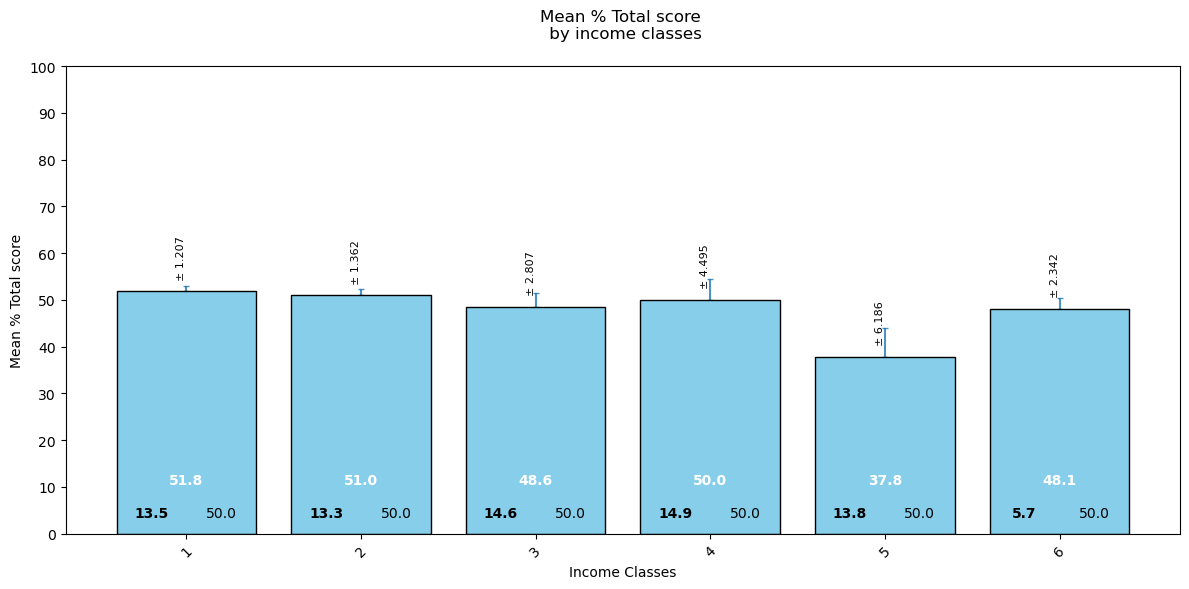

In [32]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("income")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by income classes", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Income Classes")

plt.tight_layout()
plt.show()

---

## Table 2.2 - Per income class: Mean Facet Scores

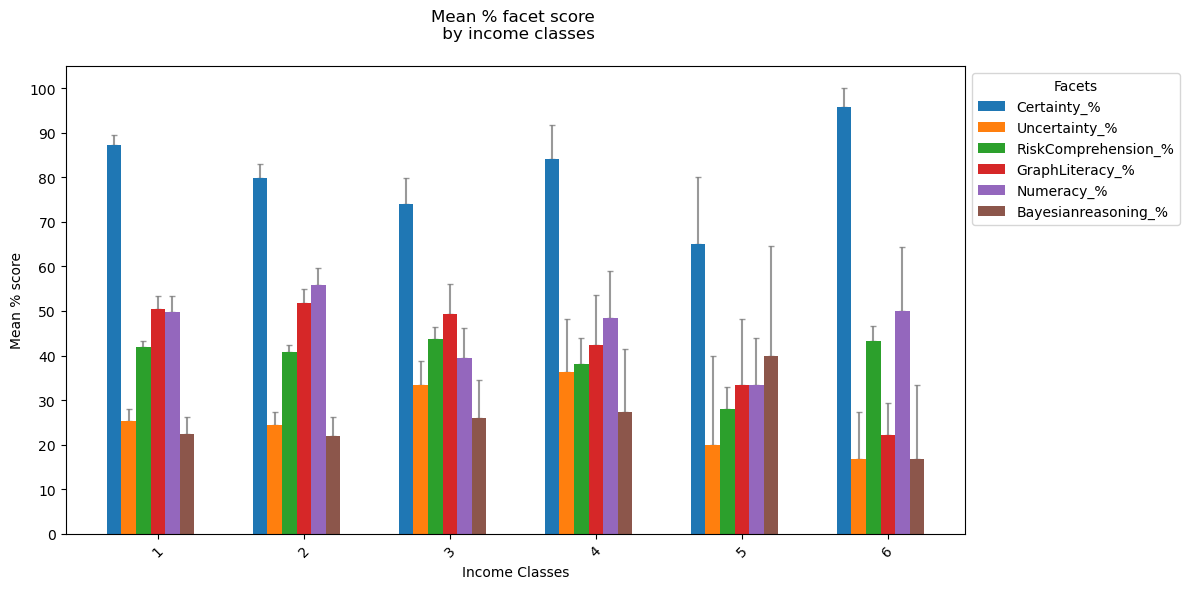

In [33]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("income")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(income_classes)/ 2 + j) * width
    axes.bar(income_classes + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(income_classes + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by income classes", pad = 20)
axes.set_ylabel("Mean % score")
axes.set_xlabel("Income Classes")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

---

## Table 3.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [34]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()

risklit_quartile = pd.qcut(income_filtered["TotalScore_18"],q = 4, labels = False ) + 1
income_filtered["risklit_quartile"] = risklit_quartile.copy()

data = income_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [35]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "income")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
# plt.show()

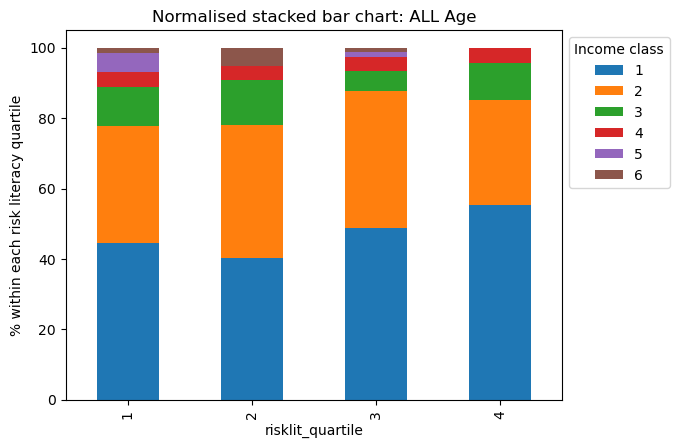

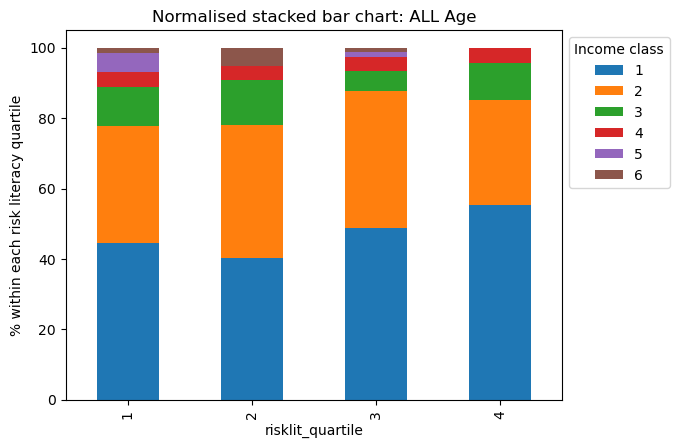

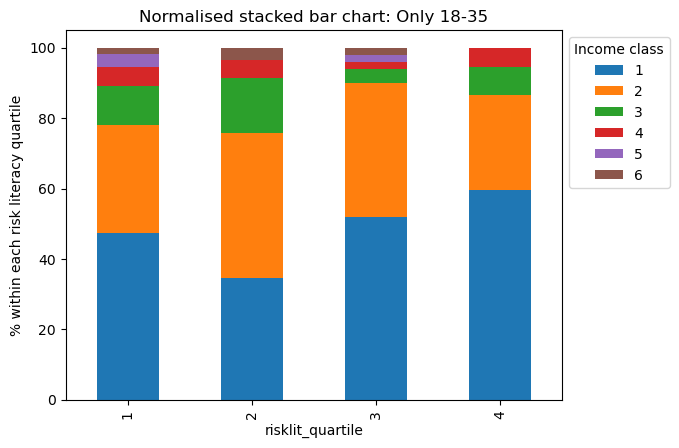

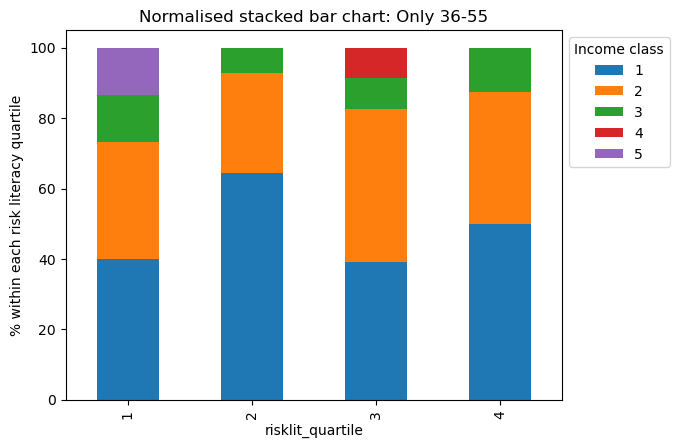

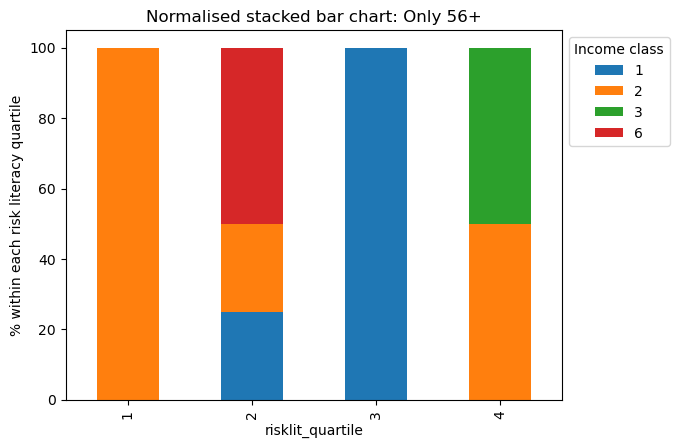

In [36]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "income")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median facet scores

Note: Wealth Class has been filtered out of entries who opted out of disclosing their income, and a quartile on the resulting data has been created

In [37]:
wealth_filtered = main.loc[ ~(pd.isnull(main["wealth"]))].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [38]:
# fig, axes = plt.subplots(4, 1, figsize = [12, 6*4])

# wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

# for i, wealth_quartile in enumerate(wealth_quartiles):
#     sample = wealth_filtered.loc[ wealth_filtered["wealth_quartile"] == wealth_quartile].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = sem,
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor wealth quartile :Q{wealth_quartile}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

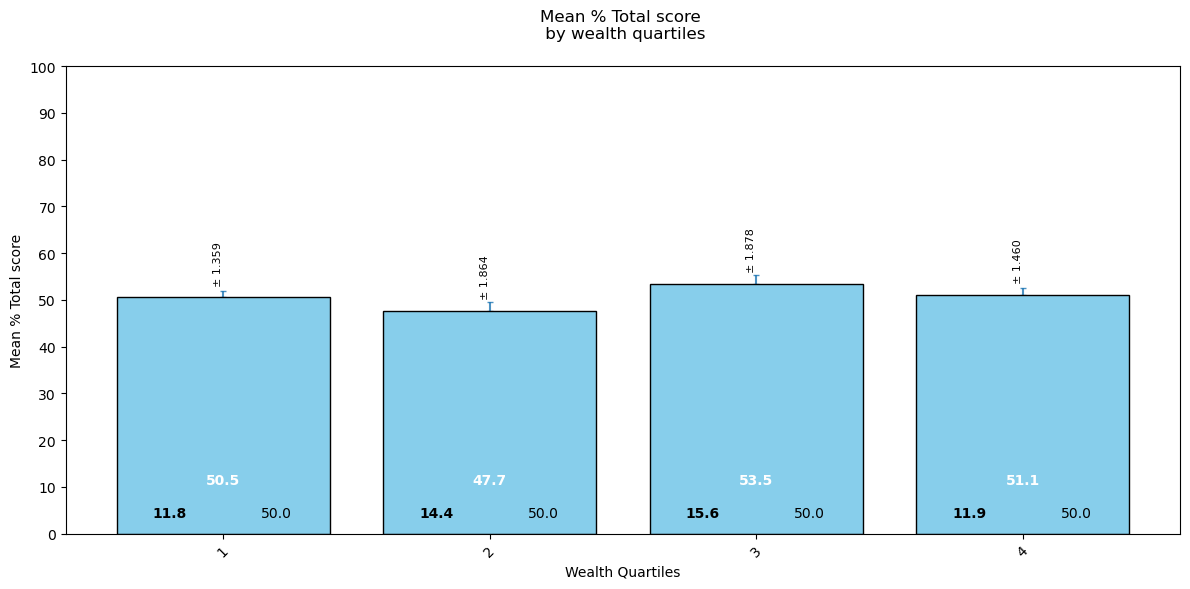

In [39]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

mean_scores = sample.groupby("wealth_quartile")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(1, 5, step = 1))

axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Wealth Quartiles")

plt.tight_layout()
plt.show()


---

## Table 2.2 - Per wealth class: Mean Facet Scores

In [40]:
income_classes

array([1, 2, 3, 4, 5, 6])

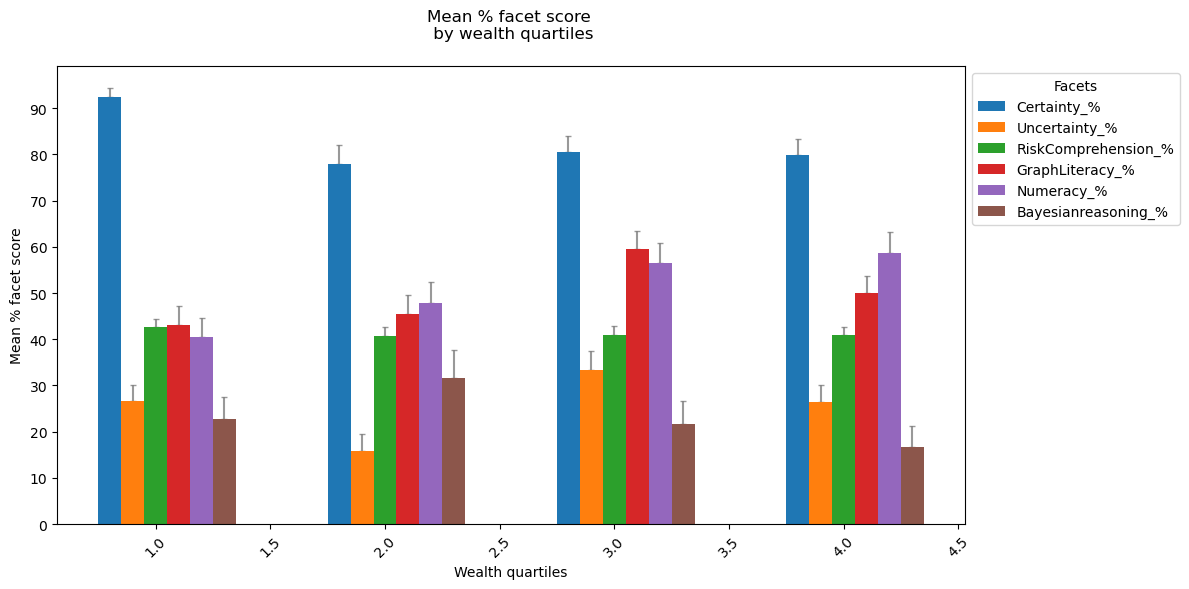

In [41]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = np.array(sorted(wealth_filtered["wealth_quartile"].unique()))

mean_scores = sample.groupby("wealth_quartile")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(wealth_quartiles)/ 2 + j) * width
    axes.bar(wealth_quartiles + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(wealth_quartiles + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % facet score")
axes.set_xlabel("Wealth quartiles")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

## Table 5.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [42]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [43]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

risklit_quartile = pd.qcut(wealth_filtered["TotalScore_18"],q = 4, labels = False ) + 1
wealth_filtered["risklit_quartile"] = risklit_quartile.copy()

data = wealth_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [44]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "wealth_quartile")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Wealth quartiles", bbox_to_anchor=(1, 1))
    
# plt.show()

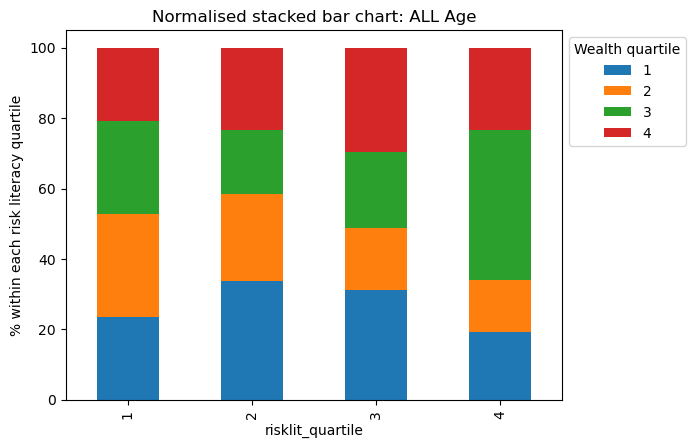

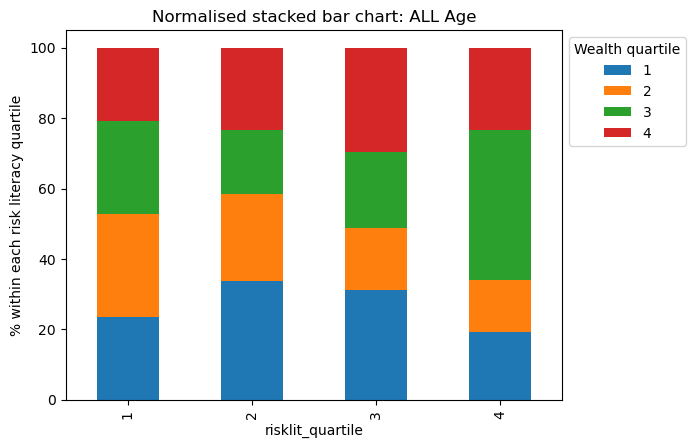

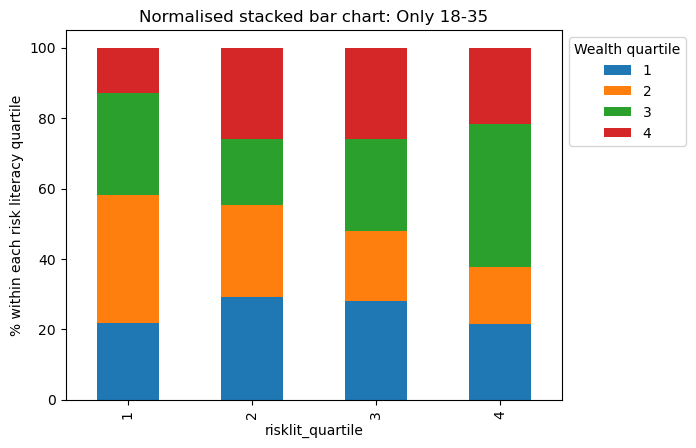

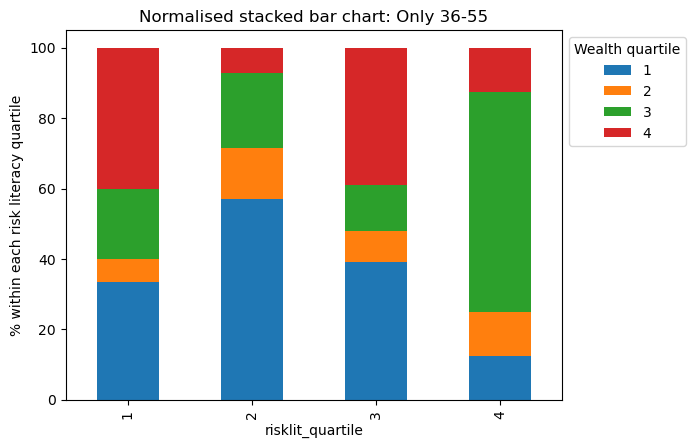

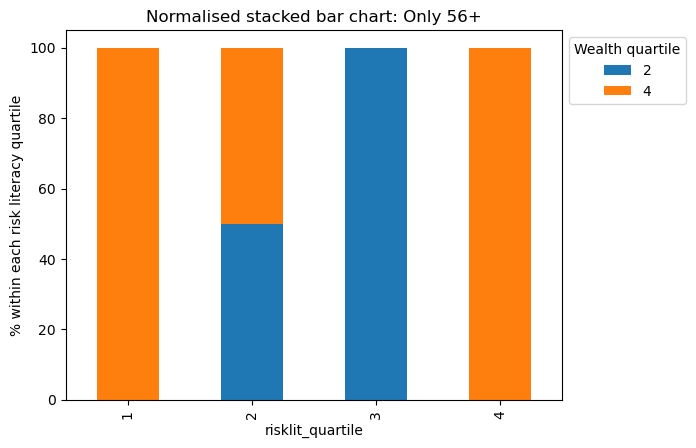

In [45]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "wealth_quartile")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Wealth quartile", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Ordinal Logistic Regression: Income Class by Risk literacy

### V1: Without any control variables

In [46]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.237916
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -334.24
Model:                   OrderedModel   AIC:                             680.5
Method:            Maximum Likelihood   BIC:                             702.1
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:16                                         
No. Observations:                 270                                         
Df Residuals:                     264                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [47]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.235283
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -333.53
Model:                   OrderedModel   AIC:                             681.1
Method:            Maximum Likelihood   BIC:                             706.2
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:17                                         
No. Observations:                 270                                         
Df Residuals:                     263                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [48]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.233031
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -332.92
Model:                   OrderedModel   AIC:                             681.8
Method:            Maximum Likelihood   BIC:                             710.6
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:17                                         
No. Observations:                 270                                         
Df Residuals:                     262                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [49]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.232794
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -332.85
Model:                   OrderedModel   AIC:                             683.7
Method:            Maximum Likelihood   BIC:                             716.1
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:17                                         
No. Observations:                 270                                         
Df Residuals:                     261                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Class by Risk literacy FOR 36-55 years old

### V1: without control of education

In [50]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.179869
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -70.792
Model:                   OrderedModel   AIC:                             151.6
Method:            Maximum Likelihood   BIC:                             162.1
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:17                                         
No. Observations:                  60                                         
Df Residuals:                      55                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [51]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.178024
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -70.681
Model:                   OrderedModel   AIC:                             153.4
Method:            Maximum Likelihood   BIC:                             165.9
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:17                                         
No. Observations:                  60                                         
Df Residuals:                      54                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [52]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.176214
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -70.573
Model:                   OrderedModel   AIC:                             155.1
Method:            Maximum Likelihood   BIC:                             169.8
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                  60                                         
Df Residuals:                      53                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Income Terciles by Risk literacy

### V1: Without any control variables

In [53]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.028881
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -277.80
Model:                   OrderedModel   AIC:                             561.6
Method:            Maximum Likelihood   BIC:                             572.4
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     267                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [54]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.026189
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -277.07
Model:                   OrderedModel   AIC:                             562.1
Method:            Maximum Likelihood   BIC:                             576.5
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     266                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [55]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.024428
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -276.60
Model:                   OrderedModel   AIC:                             563.2
Method:            Maximum Likelihood   BIC:                             581.2
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     265                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [56]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.024269
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -276.55
Model:                   OrderedModel   AIC:                             565.1
Method:            Maximum Likelihood   BIC:                             586.7
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     264                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Tercile by Risk literacy FOR 36-55 years old

### V1: without control of education

In [57]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.021766
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -61.306
Model:                   OrderedModel   AIC:                             128.6
Method:            Maximum Likelihood   BIC:                             134.9
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                  60                                         
Df Residuals:                      57                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

### V2: with control of education

In [58]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.020112
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -61.207
Model:                   OrderedModel   AIC:                             130.4
Method:            Maximum Likelihood   BIC:                             138.8
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                  60                                         
Df Residuals:                      56                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [59]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.019216
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -61.153
Model:                   OrderedModel   AIC:                             132.3
Method:            Maximum Likelihood   BIC:                             142.8
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                  60                                         
Df Residuals:                      55                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy

### V1: Without any control variables

In [60]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.380028
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -372.61
Model:                   OrderedModel   AIC:                             753.2
Method:            Maximum Likelihood   BIC:                             767.6
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     266                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [61]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.375070
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -371.27
Model:                   OrderedModel   AIC:                             752.5
Method:            Maximum Likelihood   BIC:                             770.5
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     265                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [62]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.371622
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -370.34
Model:                   OrderedModel   AIC:                             752.7
Method:            Maximum Likelihood   BIC:                             774.3
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:18                                         
No. Observations:                 270                                         
Df Residuals:                     264                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education, age and Financial Lit

In [63]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.346744
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -363.62
Model:                   OrderedModel   AIC:                             741.2
Method:            Maximum Likelihood   BIC:                             766.4
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:19                                         
No. Observations:                 270                                         
Df Residuals:                     263                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy FOR 36-55 years old

### V1: without control of education

In [64]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.293757
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -77.625
Model:                   OrderedModel   AIC:                             163.3
Method:            Maximum Likelihood   BIC:                             171.6
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:19                                         
No. Observations:                  60                                         
Df Residuals:                      56                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [65]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.293012
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -77.581
Model:                   OrderedModel   AIC:                             165.2
Method:            Maximum Likelihood   BIC:                             175.6
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:19                                         
No. Observations:                  60                                         
Df Residuals:                      55                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [66]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.237595
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -74.256
Model:                   OrderedModel   AIC:                             160.5
Method:            Maximum Likelihood   BIC:                             173.1
Date:                Sun, 06 Jul 2025                                         
Time:                        18:55:19                                         
No. Observations:                  60                                         
Df Residuals:                      54                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

---

## Financial Literacy vs risk literacy

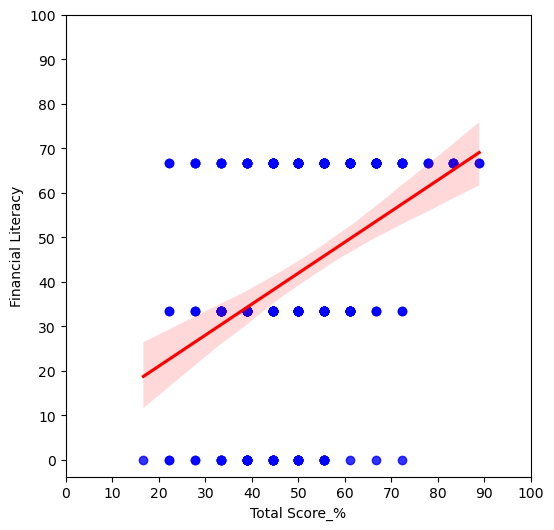

In [67]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialLiteracy_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Literacy', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()